In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
PATH_TO_PROCESSED_DATA_FOLDER = './saved/processed_data/'
PATH_TO_MODEL_CHECKPOINT = './saved/checkpoints/'
PATH_TO_TF_MODELS = './saved/models/'
PATH_TO_SCALER_FOLDER = './saved/scaler/'

In [3]:
os.makedirs(PATH_TO_MODEL_CHECKPOINT, exist_ok=True)
os.makedirs(PATH_TO_TF_MODELS, exist_ok=True)
os.makedirs(PATH_TO_SCALER_FOLDER, exist_ok=True)

In [4]:
def load_training_data(path_to_save_folder=PATH_TO_PROCESSED_DATA_FOLDER):
    """
    Load training data from .npy files stored on disk.

    Returns:
    X_ts (np.array): Time series data.
    X_aux (np.array): Auxiliary data.
    Y (np.array): Labels or target data.
    """
    X_ts = np.load(path_to_save_folder + 'X_ts.npy')
    X_aux = np.load(path_to_save_folder + 'X_aux.npy')
    Y = np.load(path_to_save_folder + 'Y.npy', allow_pickle=True)

    return X_ts, X_aux, Y


In [5]:
X_ts, X_aux, Y = load_training_data()

print(X_ts.shape)
print(X_aux.shape)
print(Y.shape)

(1312, 420, 9)
(1312, 9)
(1312, 3)


In [6]:
print(np.isnan(X_ts).any())
# TODO: Should handle in pre-processing part
X_ts = np.nan_to_num(X_ts)
print(np.isnan(X_ts).any())

True
False


In [7]:
print(np.isnan(X_aux).any())

False


In [8]:
Y = Y.astype(float)
print(np.isnan(Y).any())

False


In [9]:
print(X_ts[0:3])

[[[ 1.67206913e-01 -3.72488499e-02  3.29460800e-02 ...  2.42114277e+00
    9.16233495e-01 -1.23400365e+00]
  [ 1.43436491e-01 -6.48360252e-02 -3.16595435e-02 ...  2.32310667e+00
    9.20316342e-01 -1.23137912e+00]
  [ 1.92030966e-01 -9.65123773e-02  1.11665547e-01 ...  2.21285846e+00
    9.25319427e-01 -1.22040978e+00]
  ...
  [ 2.53773868e-01  3.19425613e-02 -1.59817219e-01 ... -2.57977759e+00
    1.47454717e+00 -2.40212575e-01]
  [ 6.21709824e-02  1.50528848e-02 -2.12077618e-01 ... -2.54493831e+00
    1.46950374e+00 -2.34700230e-01]
  [-3.69114876e-02 -6.52694702e-03 -9.32205915e-02 ... -2.48521750e+00
    1.44871788e+00 -2.32633835e-01]]

 [[ 2.66341627e-01  4.13862437e-01 -1.14130366e+00 ... -2.17251301e+00
    1.99602931e+00 -1.55519829e-01]
  [ 7.10729778e-01 -6.29920006e-01 -4.58711147e-01 ... -2.23789153e+00
    2.01293848e+00 -2.07797796e-01]
  [ 5.94094634e-01  8.86043012e-02  6.96224630e-01 ... -2.24495532e+00
    2.04118834e+00 -2.39955303e-01]
  ...
  [-1.77109241e-03  2.2

In [10]:
print(X_aux[0:3])

[[ 1.    0.    0.    0.    1.   56.   64.    0.   35.25]
 [ 1.    0.    0.    0.    1.   56.   64.    0.   35.25]
 [ 1.    0.    0.    0.    1.   56.   64.    0.   35.25]]


In [11]:
print(Y[0:3])

[[ 79.71 100.25   1.96]
 [ 79.71 100.25   1.96]
 [ 79.71 100.25   1.96]]


In [12]:
# setting a seed for reproducibility
seed = 42

X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test = train_test_split(X_ts, X_aux, Y, test_size=0.2, random_state=seed)

print("Train shapes:", X_ts_train.shape, X_aux_train.shape, Y_train.shape)
print("Test shapes:", X_ts_test.shape, X_aux_test.shape, Y_test.shape)

Train shapes: (1049, 420, 9) (1049, 9) (1049, 3)
Test shapes: (263, 420, 9) (263, 9) (263, 3)


In [13]:
print(Y_train[0:5])

[[103.55 103.55   6.33]
 [120.24 147.27   0.37]
 [126.29 151.85   1.29]
 [152.58 176.74   2.59]
 [ 27.89  57.84   3.35]]


In [14]:
def create_model_v1(X_ts_train, X_aux_train):
    Tx = X_ts_train.shape[1]

    input_ts = Input(shape=(Tx, X_ts_train.shape[2]))
    
    X = LSTM(128, return_sequences=True)(input_ts)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = LSTM(128, return_sequences=False)(X)

    input_aux = Input(shape=(X_aux_train.shape[1],))

    X = Concatenate()([X, input_aux])

    X = Dense(256, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(256, activation='relu')(X)

    # Output layer
    output = Dense(3)(X)

    model = Model(inputs=[input_ts, input_aux], outputs=output)
    return model

In [16]:
def create_and_fit_model(
        create_model_fn, model_name,
        X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test,
        epochs=100, batch_size=512, early_stop_patience=10):
    model = create_model_fn(X_ts_train, X_aux_train)
    model.compile(loss='mse', optimizer=Adam(), metrics=['mse', 'accuracy'])
    model.summary()

    # Early Stop if no improvement for 10 consecutive epoches
    early_stopping = EarlyStopping(monitor='val_loss',
                                patience=early_stop_patience, 
                                verbose=1, 
                                restore_best_weights=True)

    model_checkpoint = ModelCheckpoint(os.path.join(PATH_TO_MODEL_CHECKPOINT, '{}_best.h5'.format(model_name)),
                                    monitor='val_loss', 
                                    save_best_only=True,
                                    verbose=1)
    loss = model.fit(
        [X_ts_train, X_aux_train],
        Y_train,
        validation_data=([X_ts_test, X_aux_test], Y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Save Model
    model_save_dir = os.path.join(PATH_TO_TF_MODELS, model_name)
    os.makedirs(model_save_dir, exist_ok=True)
    model.save(model_save_dir)

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss.history['loss'], label='Training Loss')
    plt.plot(loss.history['val_loss'], label='Validation Loss') 
    plt.title('Loss over time')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    return model

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 420, 9)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 420, 128)     70656       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 420, 128)     0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 420, 128)     131584      ['dropout[0][0]']                
                 

2023-06-05 00:43:05.054575: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - ETA: 0s - loss: 11518.0000 - mse: 11518.0000 - accuracy: 0.9695
Epoch 1: val_loss improved from inf to 8853.26953, saving model to ./saved/checkpoints/model_v1_best.h5
3/3 [==============================] - 27s 7s/step - loss: 11518.0000 - mse: 11518.0000 - accuracy: 0.9695 - val_loss: 8853.2695 - val_mse: 8853.2695 - val_accuracy: 0.9696
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 7986.7202 - mse: 7986.7202 - accuracy: 0.9695
Epoch 2: val_loss improved from 8853.26953 to 5155.36230, saving model to ./saved/checkpoints/model_v1_best.h5
3/3 [==============================] - 8s 2s/step - loss: 7986.7202 - mse: 7986.7202 - accuracy: 0.9695 - val_loss: 5155.3623 - val_mse: 5155.3623 - val_accuracy: 0.9696
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 4075.2361 - mse: 4075.2361 - accuracy: 0.9695
Epoch 3: val_loss improved from 5155.36230 to 1484.57251, saving model to ./saved/checkpoints/model_v1_best.h5
3/

INFO:tensorflow:Assets written to: ./saved/models/model_v1/assets


INFO:tensorflow:Assets written to: ./saved/models/model_v1/assets


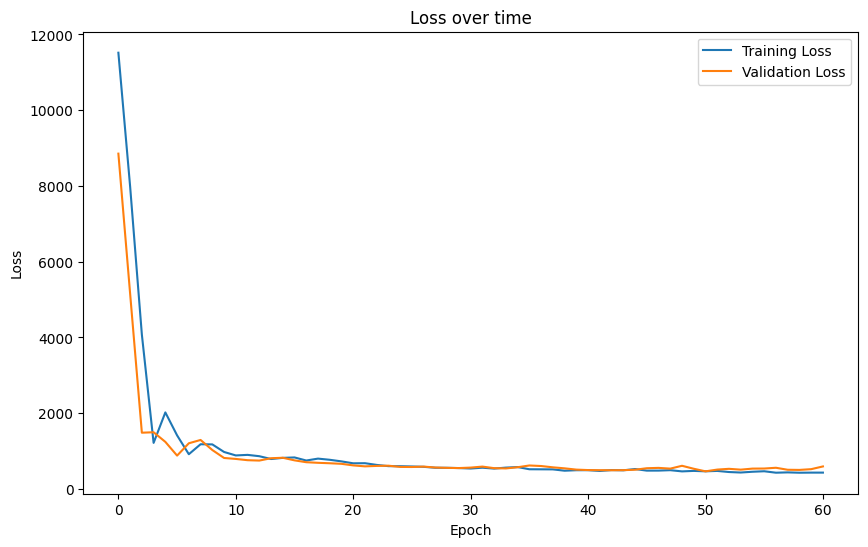

In [16]:
model_v1 = create_and_fit_model(create_model_v1, 'model_v1', X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test)

In [17]:
def visualize_result(model, X_ts_test, X_aux_test, Y_test, scaler_Y=None):
    # Predict the values
    y_pred = model.predict([X_ts_test, X_aux_test])

    # Create a figure
    fig = plt.figure(figsize=(10, 15))  # Adjust the size as needed

    # Plot each graph
    for i in range(3):
        # Create a subplot
        ax = fig.add_subplot(3, 1, i + 1)

        # Calculate the range of values
        min_val = min(y_pred[:, i].min(), Y_test[:, i].min())
        max_val = max(y_pred[:, i].max(), Y_test[:, i].max())

        ax.scatter(Y_test[:, i], y_pred[:, i])
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.axis('equal')
        ax.axis('square')
        ax.set_xlim([min_val, max_val])
        ax.set_ylim([min_val, max_val])

        if i == 0:
            ax.set_title(f'Pred vs Real for output Carry Distance')
        elif i == 1:
            ax.set_title(f'Pred vs Real for output Total Distance')
        else:
            ax.set_title(f'Pred vs Real for output Attack Angle')

    plt.tight_layout()
    plt.show()

    if scaler_Y is not None:
        Y_test = scaler_Y.inverse_transform(Y_test)
        
    # Print some samples
    for sample_index in range(2, 15):
        print(sample_index)
        x_ts_sample, x_aux_sample = X_ts_test[sample_index], X_aux_test[sample_index]

        x_ts_sample = np.expand_dims(x_ts_sample, axis=0)
        x_aux_sample = np.expand_dims(x_aux_sample, axis=0)
        predictions = model.predict([x_ts_sample, x_aux_sample])
        if scaler_Y is not None:
            predictions = scaler_Y.inverse_transform(predictions)

        print('Predict: {:.2f}, {:.2f}, {:.2f}'.format(*predictions[0]))
        print('Real: {:.2f}, {:.2f}, {:.2f}'.format(*Y_test[sample_index]))
        print("="*100)

As this is a regression problem with multiple outputs, the accuracy does not mean much to us, and we should rely more on the MSE to evaluate our model.

As we can see from the code below, the predictions, while generally go in the same direction as the real value, are still far off from the real value. It also seems to simply output roughly the same value for Attack Angle (maybe that is the average and yield the lowest MSE). This might be because most data are very dense around (-2, 2) range and not enough data at the extreme for the model to learn pattern from.

We should also note that the attack angle is relatively small in magnitude compared to the other two, so its effect on MSE might be small, causing the model to "spend more effort" predicting the other two values.

We might want to normalize Y to combat this effect.

9/9 [==============================] - 6s 388ms/step


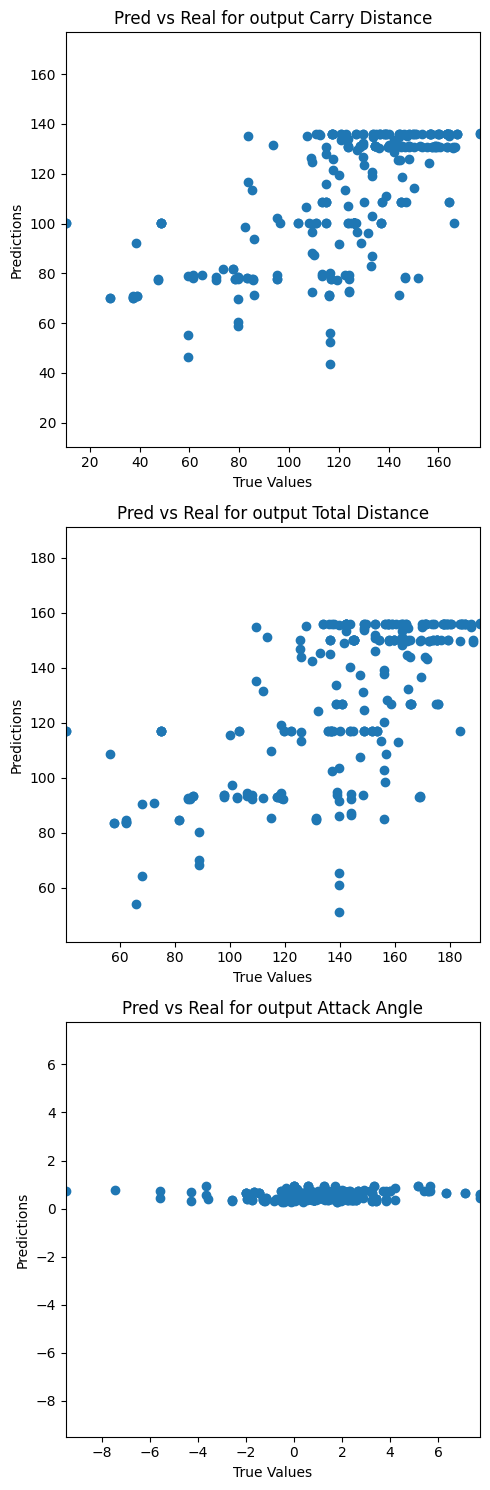

2
1/1 [==============================] - 2s 2s/step
Predict: 108.69, 126.86, 0.68
Real: 164.44, 175.94, 1.11
3
1/1 [==============================] - 0s 199ms/step
Predict: 130.96, 150.09, 0.36
Real: 159.46, 174.03, 2.27
4
1/1 [==============================] - 0s 173ms/step
Predict: 135.99, 155.97, 0.41
Real: 151.13, 174.22, -3.59
5
1/1 [==============================] - 0s 193ms/step
Predict: 136.07, 156.04, 0.40
Real: 176.84, 191.12, 0.94
6
1/1 [==============================] - 0s 207ms/step
Predict: 79.99, 91.59, 0.43
Real: 116.29, 139.86, -0.34
7
1/1 [==============================] - 0s 178ms/step
Predict: 126.16, 145.37, 0.29
Real: 109.01, 132.88, 1.79
8
1/1 [==============================] - 0s 179ms/step
Predict: 100.33, 117.09, 0.66
Real: 110.80, 122.31, 0.34
9
1/1 [==============================] - 0s 190ms/step
Predict: 79.65, 94.90, 0.75
Real: 113.22, 139.09, 2.92
10
1/1 [==============================] - 0s 188ms/step
Predict: 135.99, 155.98, 0.40
Real: 157.16, 171.25, 0

In [18]:
visualize_result(model_v1, X_ts_test, X_aux_test, Y_test)

In [19]:
def create_model_v2(X_ts_train, X_aux_train):
    Tx = X_ts_train.shape[1]

    input_ts = Input(shape=(Tx, X_ts_train.shape[2]))
    
    X = LSTM(64, return_sequences=True)(input_ts)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)
    X = LSTM(64, return_sequences=True)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)
    X = LSTM(64, return_sequences=False)(X)

    input_aux = Input(shape=(X_aux_train.shape[1],))
    X_aux = BatchNormalization()(input_aux)

    X = Concatenate()([X, X_aux])

    X = Dense(256, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(256, activation='relu')(X)

    # Output layer
    output = Dense(3)(X)

    model = Model(inputs=[input_ts, input_aux], outputs=output)
    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 420, 9)]     0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 420, 64)      18944       ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 420, 64)     256         ['lstm_3[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout_2 (Dropout)            (None, 420, 64)      0           ['batch_normalization[0][0]

INFO:tensorflow:Assets written to: ./saved/models/model_v2/assets


INFO:tensorflow:Assets written to: ./saved/models/model_v2/assets


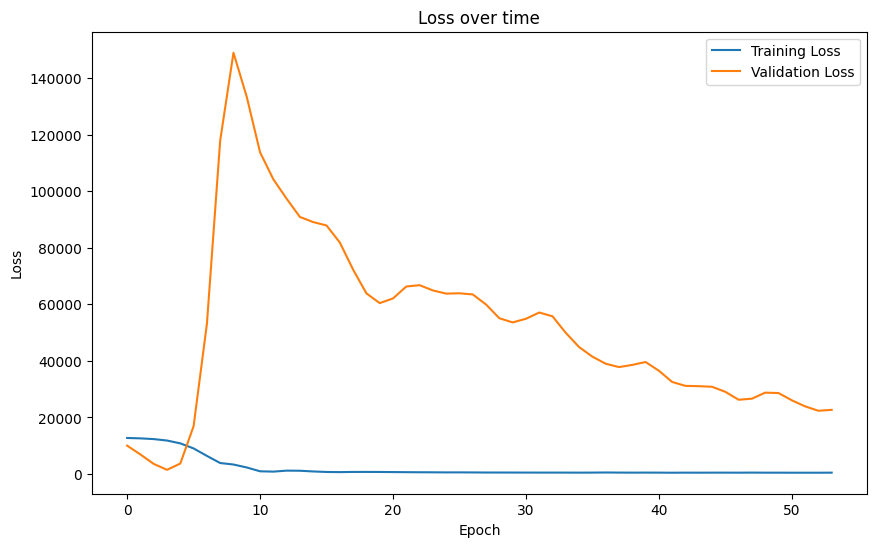

In [20]:
model_v2 = create_and_fit_model(create_model_v2, 'model_v2', X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test, early_stop_patience=50)

Seems like the model no longer have enough DF to fit anything so it ended up just outputing a number around the same value for each of our input... we might be normalizing/droping too much too late in the model.

9/9 [==============================] - 8s 567ms/step


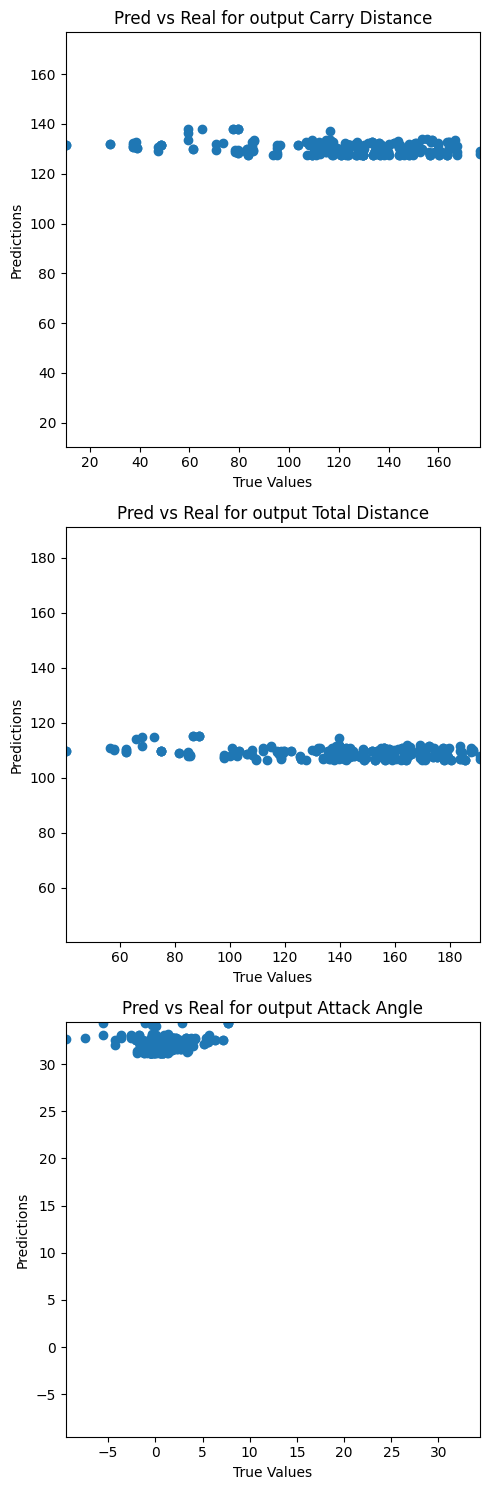

2
1/1 [==============================] - 2s 2s/step
Predict: 130.12, 108.78, 32.03
Real: 164.44, 175.94, 1.11
3
1/1 [==============================] - 0s 234ms/step
Predict: 128.67, 107.72, 31.64
Real: 159.46, 174.03, 2.27
4
1/1 [==============================] - 0s 213ms/step
Predict: 132.55, 110.77, 32.73
Real: 151.13, 174.22, -3.59
5
1/1 [==============================] - 0s 209ms/step
Predict: 127.90, 107.02, 31.36
Real: 176.84, 191.12, 0.94
6
1/1 [==============================] - 0s 196ms/step
Predict: 133.45, 111.63, 33.08
Real: 116.29, 139.86, -0.34
7
1/1 [==============================] - 0s 192ms/step
Predict: 132.71, 110.91, 32.77
Real: 109.01, 132.88, 1.79
8
1/1 [==============================] - 0s 183ms/step
Predict: 131.46, 109.92, 32.50
Real: 110.80, 122.31, 0.34
9
1/1 [==============================] - 0s 288ms/step
Predict: 130.12, 108.78, 32.04
Real: 113.22, 139.09, 2.92
10
1/1 [==============================] - 0s 214ms/step
Predict: 132.78, 110.97, 32.79
Real: 157.

In [21]:
visualize_result(model_v2, X_ts_test, X_aux_test, Y_test)

In [17]:
def create_model_v3(X_ts_train, X_aux_train):
    Tx = X_ts_train.shape[1]

    input_ts = Input(shape=(Tx, X_ts_train.shape[2]))
    
    X = LSTM(128, return_sequences=True)(input_ts)
    X = LSTM(128, return_sequences=True)(X)
    X = LSTM(128, return_sequences=False)(X)

    input_aux = Input(shape=(X_aux_train.shape[1],))

    X = Concatenate()([X, input_aux])

    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(128, activation='relu')(X)
    X = Dense(64, activation='relu')(X)

    # Output layer
    output = Dense(3)(X)

    model = Model(inputs=[input_ts, input_aux], outputs=output)
    return model

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 420, 9)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 420, 128)     70656       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 420, 128)     131584      ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          131584      ['lstm_1[0][0]']                 
                 

2023-06-05 01:16:38.864162: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - ETA: 0s - loss: 12720.4199 - mse: 12720.4199 - accuracy: 0.4652
Epoch 1: val_loss improved from inf to 11339.93164, saving model to ./saved/checkpoints/model_v3_best.h5
3/3 [==============================] - 26s 7s/step - loss: 12720.4199 - mse: 12720.4199 - accuracy: 0.4652 - val_loss: 11339.9316 - val_mse: 11339.9316 - val_accuracy: 0.9696
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 12456.7822 - mse: 12456.7822 - accuracy: 0.9638
Epoch 2: val_loss improved from 11339.93164 to 9935.08594, saving model to ./saved/checkpoints/model_v3_best.h5
3/3 [==============================] - 10s 3s/step - loss: 12456.7822 - mse: 12456.7822 - accuracy: 0.9638 - val_loss: 9935.0859 - val_mse: 9935.0859 - val_accuracy: 0.9696
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 11978.3770 - mse: 11978.3770 - accuracy: 0.9695
Epoch 3: val_loss improved from 9935.08594 to 7847.04492, saving model to ./saved/checkpoints/model_v3

INFO:tensorflow:Assets written to: ./saved/models/model_v3/assets


INFO:tensorflow:Assets written to: ./saved/models/model_v3/assets


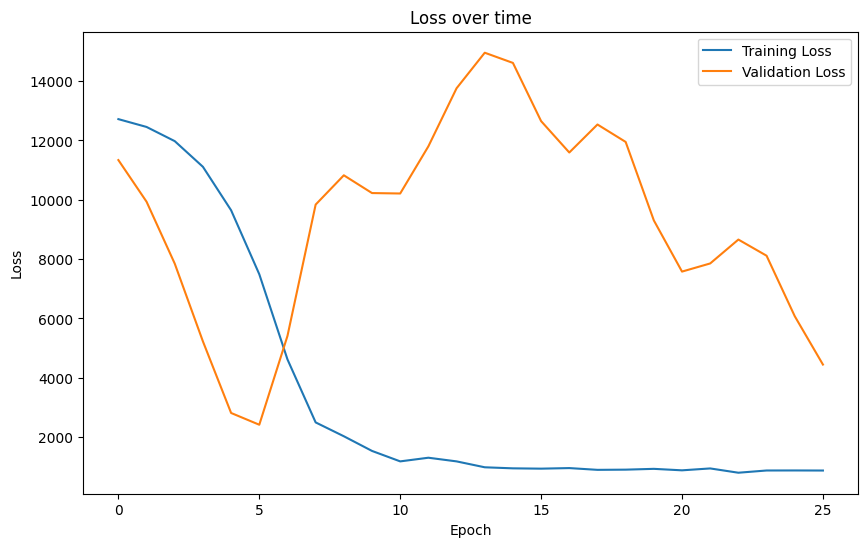

In [18]:
model_v3 = create_and_fit_model(create_model_v3, 'model_v3', X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test, early_stop_patience=20)

9/9 [==============================] - 7s 539ms/step


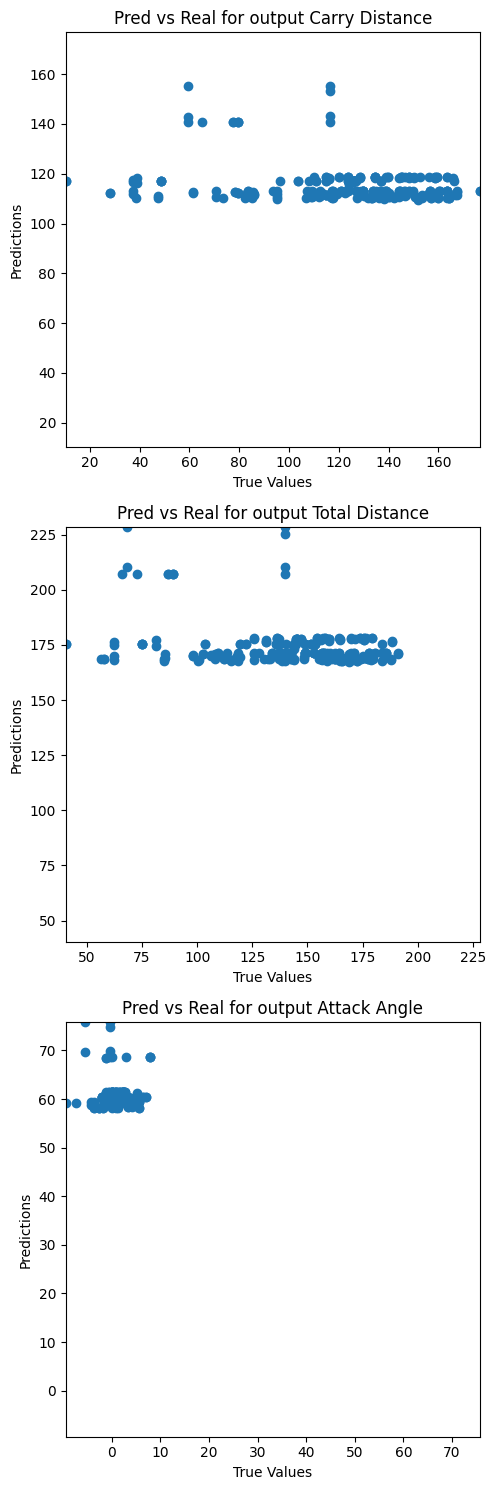

2
1/1 [==============================] - 2s 2s/step
Predict: 111.61, 169.19, 59.40
Real: 164.44, 175.94, 1.11
3
1/1 [==============================] - 0s 178ms/step
Predict: 118.80, 177.96, 61.48
Real: 159.46, 174.03, 2.27
4
1/1 [==============================] - 0s 206ms/step
Predict: 110.52, 168.64, 59.37
Real: 151.13, 174.22, -3.59
5
1/1 [==============================] - 0s 217ms/step
Predict: 113.11, 171.36, 60.25
Real: 176.84, 191.12, 0.94
6
1/1 [==============================] - 0s 171ms/step
Predict: 155.34, 228.35, 75.78
Real: 116.29, 139.86, -0.34
7
1/1 [==============================] - 0s 191ms/step
Predict: 110.46, 168.56, 59.34
Real: 109.01, 132.88, 1.79
8
1/1 [==============================] - 0s 175ms/step
Predict: 116.99, 175.22, 60.48
Real: 110.80, 122.31, 0.34
9
1/1 [==============================] - 0s 176ms/step
Predict: 111.93, 169.61, 59.54
Real: 113.22, 139.09, 2.92
10
1/1 [==============================] - 0s 176ms/step
Predict: 110.43, 168.49, 59.32
Real: 157.

In [19]:
visualize_result(model_v3, X_ts_test, X_aux_test, Y_test)

In [29]:
# Try model_v1 with normalized data. The normalization is done here so we can compare the different
# one with and without normalization

from sklearn.preprocessing import MinMaxScaler

scaler_X_ts = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

# Load data from file again, so we don't accidentally transform transformed values
X_ts, X_aux, Y = load_training_data()
X_ts = np.nan_to_num(X_ts)

# First, reshape the time series data into 2D so that it can be fit to the scaler
X_ts_2d = X_ts.reshape(-1, X_ts.shape[-1])
# Fit the scaler and transform the data
X_ts_2d = scaler_X_ts.fit_transform(X_ts_2d)
# Finally, reshape it back to the original shape
X_ts = X_ts_2d.reshape(X_ts.shape)

Y = scaler_Y.fit_transform(Y)

with open(os.path.join(PATH_TO_SCALER_FOLDER, 'scaler_X_ts.pkl'), 'wb') as f:
    pickle.dump(scaler_X_ts, f)

with open(os.path.join(PATH_TO_SCALER_FOLDER,'scaler_Y.pkl'), 'wb') as f:
    pickle.dump(scaler_Y, f)

# We probably should not normalize the one-hot encoding and other categorical values, especially given
# that not all category values are represented in our data...
# scaler_X_aux = MinMaxScaler(feature_range=(-1, 1))
# X_aux = scaler_X_aux.fit_transform(X_aux)
# with open(os.path.join(PATH_TO_SCALER_FOLDER, 'scaler_X_aux.pkl'), 'wb') as f:
#     pickle.dump(scaler_X_aux, f)

In [30]:
def load_scalers():
    with open(os.path.join(PATH_TO_SCALER_FOLDER, 'scaler_X_ts.pkl'), 'rb') as f:
        scaler_X_ts = pickle.load(f)

    # with open(os.path.join(PATH_TO_SCALER_FOLDER, 'scaler_X_aux.pkl'), 'rb') as f:
    #     scaler_X_aux = pickle.load(f)

    with open(os.path.join(PATH_TO_SCALER_FOLDER,'scaler_Y.pkl'), 'rb') as f:
        scaler_Y = pickle.load(f)

    return scaler_X_ts, scaler_Y

In [31]:
print(X_ts)

[[[-0.34981629 -0.3352359  -0.41735433 ...  0.77067512  0.29200859
   -0.76792415]
  [-0.35259877 -0.33776618 -0.42231076 ...  0.73946921  0.29331271
   -0.76608158]
  [-0.34691047 -0.34067152 -0.41131511 ...  0.70437606  0.29491077
   -0.75838044]
  ...
  [-0.33968305 -0.32888969 -0.43214279 ... -0.82116978  0.4703427
   -0.07022293]
  [-0.36211144 -0.33043881 -0.43615212 ... -0.81008007  0.46873175
   -0.06635293]
  [-0.3737097  -0.3324181  -0.42703362 ... -0.79107032  0.46209242
   -0.0649022 ]]

 [[-0.33821191 -0.29386017 -0.50744071 ... -0.69153323  0.63691224
   -0.01076352]
  [-0.28619333 -0.38959543 -0.45507341 ... -0.71234389  0.64231329
   -0.0474658 ]
  [-0.29984624 -0.3236927  -0.36646877 ... -0.71459237  0.65133674
   -0.07004231]
  ...
  [-0.36959628 -0.33161511 -0.41872744 ... -0.72868501  0.42360138
    0.10252381]
  [-0.37211582 -0.33190168 -0.41893247 ... -0.72859056  0.42320086
    0.10170142]
  [-0.37155991 -0.33372478 -0.4182047  ... -0.72848024  0.42312756
    0.1

In [32]:
print(X_aux)

[[ 1.    0.    0.   ... 64.    0.   35.25]
 [ 1.    0.    0.   ... 64.    0.   35.25]
 [ 1.    0.    0.   ... 64.    0.   35.25]
 ...
 [ 1.    0.    0.   ... 62.5   4.6  38.5 ]
 [ 1.    0.    0.   ... 62.5   4.6  38.5 ]
 [ 1.    0.    0.   ... 62.5   4.6  38.5 ]]


In [24]:
print(Y)

[[-0.1664465  -0.20589211  0.32830626]
 [-0.1664465  -0.20589211  0.32830626]
 [-0.1664465  -0.20589211  0.32830626]
 ...
 [ 0.63924583  0.70725234  0.03828306]
 [ 0.63924583  0.70725234  0.03828306]
 [ 0.63924583  0.70725234  0.03828306]]


In [33]:
# note that while we are using the same seed, we might still get different shuffling result
seed = 42

X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test = train_test_split(X_ts, X_aux, Y, test_size=0.2, random_state=seed)

print("Train shapes:", X_ts_train.shape, X_aux_train.shape, Y_train.shape)
print("Test shapes:", X_ts_test.shape, X_aux_test.shape, Y_test.shape)

Train shapes: (1049, 420, 9) (1049, 9) (1049, 3)
Test shapes: (263, 420, 9) (263, 9) (263, 3)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 420, 9)]     0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 420, 128)     70656       ['input_13[0][0]']               
                                                                                                  
 dropout_12 (Dropout)           (None, 420, 128)     0           ['lstm_18[0][0]']                
                                                                                                  
 lstm_19 (LSTM)                 (None, 420, 128)     131584      ['dropout_12[0][0]']             
                                                                                            

INFO:tensorflow:Assets written to: ./saved/models/model_v1_with_normalized_data/assets


INFO:tensorflow:Assets written to: ./saved/models/model_v1_with_normalized_data/assets


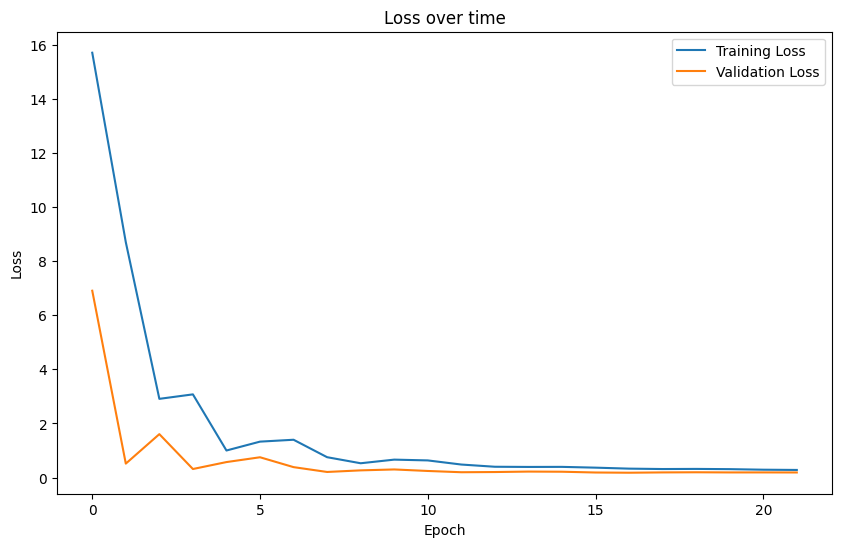

In [34]:
model_v1_with_normalized_data = create_and_fit_model(
    create_model_v1, 
    'model_v1_with_normalized_data', 
    X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test, 
    epochs=30, 
    early_stop_patience=5
)

9/9 [==============================] - 6s 392ms/step


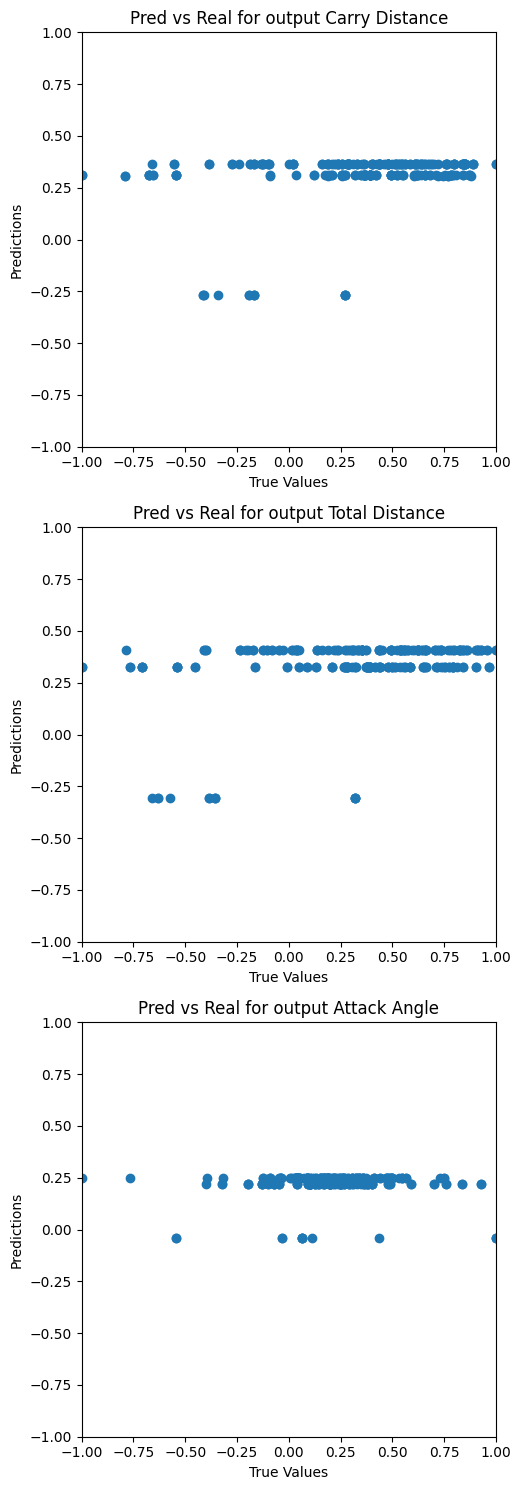

2
1/1 [==============================] - 2s 2s/step
Predict: 124.11, 146.47, 1.26
Real: 164.44, 175.94, 1.11
3
1/1 [==============================] - 0s 179ms/step
Predict: 119.32, 140.19, 1.03
Real: 159.46, 174.03, 2.27
4
1/1 [==============================] - 0s 170ms/step
Predict: 124.10, 146.47, 1.26
Real: 151.13, 174.22, -3.59
5
1/1 [==============================] - 0s 171ms/step
Predict: 124.12, 146.44, 1.25
Real: 176.84, 191.12, 0.94
6
1/1 [==============================] - 0s 188ms/step
Predict: 71.45, 92.64, -1.22
Real: 116.29, 139.86, -0.34
7
1/1 [==============================] - 0s 183ms/step
Predict: 124.10, 146.48, 1.26
Real: 109.01, 132.88, 1.79
8
1/1 [==============================] - 0s 178ms/step
Predict: 119.31, 140.23, 1.04
Real: 110.80, 122.31, 0.34
9
1/1 [==============================] - 0s 176ms/step
Predict: 124.11, 146.47, 1.26
Real: 113.22, 139.09, 2.92
10
1/1 [==============================] - 0s 171ms/step
Predict: 124.10, 146.48, 1.26
Real: 157.16, 171.25

In [27]:
visualize_result(model_v1_with_normalized_data, X_ts_test, X_aux_test, Y_test, scaler_Y)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler_X_ts = StandardScaler()
scaler_X_aux = StandardScaler()
scaler_Y = StandardScaler()

# Load data from file again, so we don't accidentally transform transformed values
X_ts, X_aux, Y = load_training_data()
X_ts = np.nan_to_num(X_ts)

X_aux = scaler_X_aux.fit_transform(X_aux)

# First, reshape the time series data into 2D so that it can be fit to the scaler
X_ts_2d = X_ts.reshape(-1, X_ts.shape[-1])
# Fit the scaler and transform the data
X_ts_2d = scaler_X_ts.fit_transform(X_ts_2d)
# Finally, reshape it back to the original shape
X_ts = X_ts_2d.reshape(X_ts.shape)

Y = scaler_Y.fit_transform(Y)

with open(os.path.join(PATH_TO_SCALER_FOLDER, 'scaler_X_ts_standard_scaler.pkl'), 'wb') as f:
    pickle.dump(scaler_X_ts, f)

with open(os.path.join(PATH_TO_SCALER_FOLDER, 'scaler_X_aux_standard_scaler.pkl'), 'wb') as f:
    pickle.dump(scaler_X_ts, f)

with open(os.path.join(PATH_TO_SCALER_FOLDER,'scaler_Y_standard_scaler.pkl'), 'wb') as f:
    pickle.dump(scaler_Y, f)

# note that while we are using the same seed, we might still get different shuffling result
seed = 42

X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test = train_test_split(X_ts, X_aux, Y, test_size=0.2, random_state=seed)

print("Train shapes:", X_ts_train.shape, X_aux_train.shape, Y_train.shape)
print("Test shapes:", X_ts_test.shape, X_aux_test.shape, Y_test.shape)

Train shapes: (1049, 420, 9) (1049, 9) (1049, 3)
Test shapes: (263, 420, 9) (263, 9) (263, 3)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 420, 9)]     0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 420, 128)     70656       ['input_9[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 420, 128)     0           ['lstm_12[0][0]']                
                                                                                                  
 lstm_13 (LSTM)                 (None, 420, 128)     131584      ['dropout_8[0][0]']              
                                                                                            

INFO:tensorflow:Assets written to: ./saved/models/model_v1_with_normalized_data_std_scaler/assets


INFO:tensorflow:Assets written to: ./saved/models/model_v1_with_normalized_data_std_scaler/assets


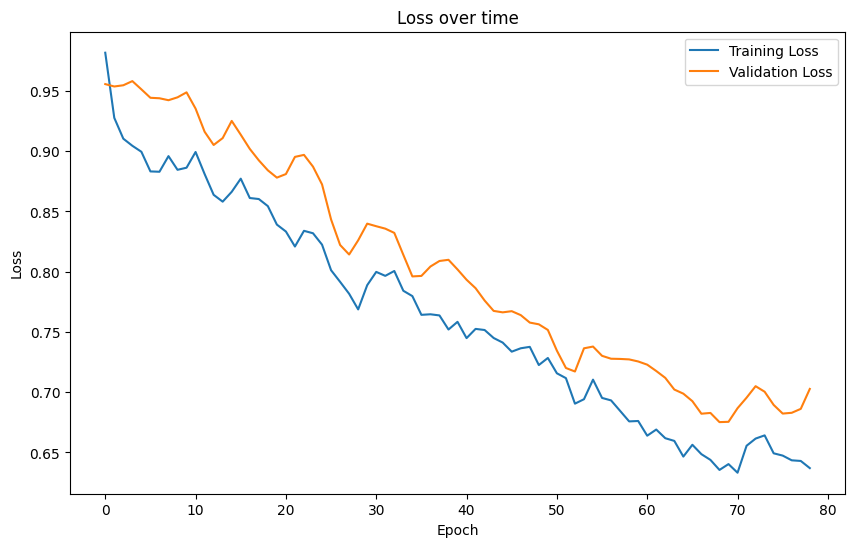

In [26]:
model_v1_with_normalized_data_std_scaler = create_and_fit_model(
    create_model_v1, 
    'model_v1_with_normalized_data_std_scaler', 
    X_ts_train, X_ts_test, X_aux_train, X_aux_test, Y_train, Y_test, 
    epochs=100, 
    early_stop_patience=10
)

This seems to result in better fit for Carry Distance and Total Distance but still relatively bad fit for Attack Angle...
Interestingly, using lower value for early_stop_patience and/or training for less number of epochs seems to yield much visualized scatter plot, even though the loss function graph seems like it can continue further.

This likely indicate that we are overfitting at higher epochs. Adding more regularization might help.

9/9 [==============================] - 6s 414ms/step


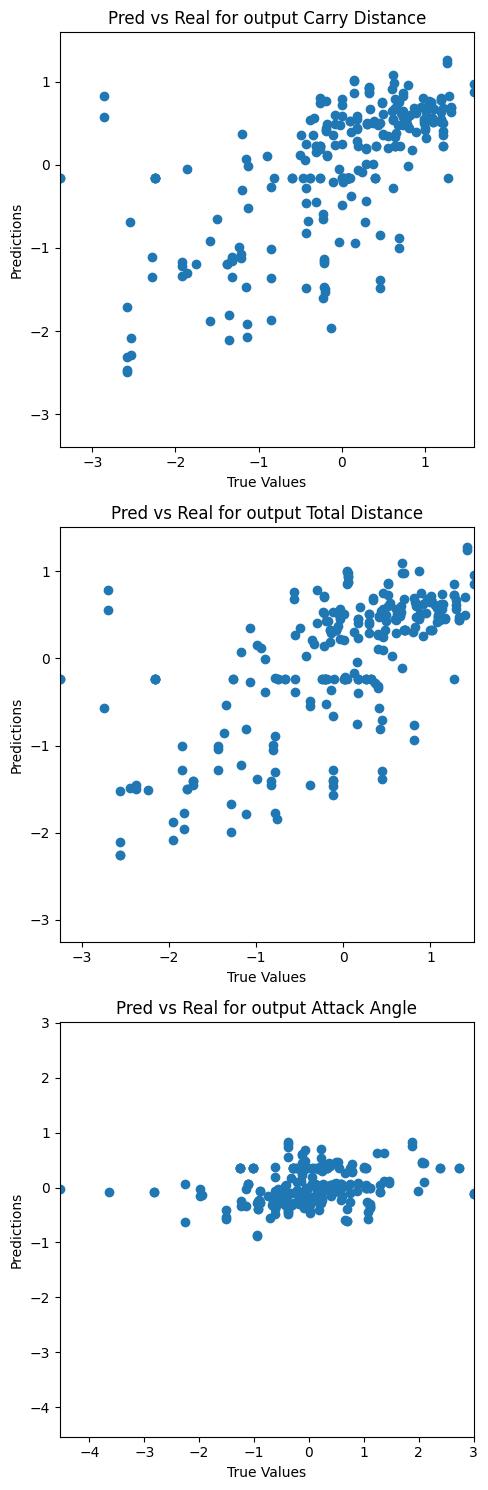

2
1/1 [==============================] - 2s 2s/step
Predict: 131.10, 153.69, 1.00
Real: 164.44, 175.94, 1.11
3
1/1 [==============================] - 0s 184ms/step
Predict: 148.97, 164.93, 0.53
Real: 159.46, 174.03, 2.27
4
1/1 [==============================] - 0s 170ms/step
Predict: 143.48, 164.53, 0.55
Real: 151.13, 174.22, -3.59
5
1/1 [==============================] - 0s 175ms/step
Predict: 152.97, 170.45, -0.09
Real: 176.84, 191.12, 0.94
6
1/1 [==============================] - 0s 179ms/step
Predict: 85.55, 99.25, 0.69
Real: 116.29, 139.86, -0.34
7
1/1 [==============================] - 0s 174ms/step
Predict: 125.62, 148.53, 0.98
Real: 109.01, 132.88, 1.79
8
1/1 [==============================] - 0s 183ms/step
Predict: 118.23, 136.01, 1.71
Real: 110.80, 122.31, 0.34
9
1/1 [==============================] - 0s 179ms/step
Predict: 128.65, 152.77, 1.04
Real: 113.22, 139.09, 2.92
10
1/1 [==============================] - 0s 190ms/step
Predict: 138.49, 159.93, 0.84
Real: 157.16, 171.25

In [27]:
visualize_result(model_v1_with_normalized_data_std_scaler, X_ts_test, X_aux_test, Y_test, scaler_Y)